## Demo for creating Figure2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import beeswarm # for beeswarm plot, pybeeswarm module is required

import bdds

### Load Data

In [6]:
# path to the unzipped files 
data_path = '../data/'

# data initiation
decoded_dnn = bdds.DecodedDNN(data_path, verbose=False)

# Set parameters
subjects = ['S1', 'S2', 'S3', 'S4', 'S5']
net      = 'AlexNet'
#net      = 'VGG19'

# Layers 
if net == 'AlexNet':
    layers   = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 
                'fc6', 'fc7', 'fc8' ]
elif net == 'VGG19':
    layers   = ['conv1_1', 'conv1_2', 
                'conv2_1', 'conv2_2',
                'conv3_1','conv3_2','conv3_3','conv3_4', 
                'conv4_1','conv4_2','conv4_3','conv4_4', 
                'conv5_1','conv5_2','conv5_3','conv5_4', 
                'fc6', 'fc7', 'fc8' ]
else:
    raise Exception('net should be AlexNet or VGG19 : net = ' + net)

    
# Exract 'accuracy' data 
# If data not exists in data_path, download it from figshare.com
n_layers = len(layers)
acc_mean = []
acc_data = {}
for layer in layers:
    acc = decoded_dnn.get(mode='accuracy', subject=subjects, net=net, layer=layer) 
    acc_data.update({layer: acc})
    acc_mean.append(np.nanmean(acc))

### Figures

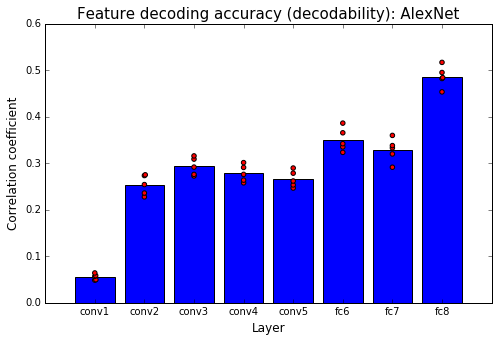

In [7]:
# Figure 2a ( Feature decoding accuracy )

## for beeswarm plot
acc_each_subject_dict = {}
for k, v in acc_data.items():
    acc_each_subject_dict.update({k:[]})
    for d in v:
        acc_each_subject_dict[k].append(d.mean())
acc_each_subject = [ np.array(acc_each_subject_dict[layer]) for layer in layers ]
##
    
## plot    
fig = plt.figure(figsize=(n_layers,5))
plt.bar(range(n_layers), acc_mean, tick_label=layers, align='center', zorder=1)
beeswarm.beeswarm(acc_each_subject, method="swarm", ax=fig.axes[0], s= 1, col='red',zorder=2 )

plt.ylim( [0.0,0.6])
plt.xlim( [-1.0, n_layers])
plt.title('Feature decoding accuracy (decodability): ' + net, fontsize=15)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Correlation coefficient', fontsize=12)
plt.show()

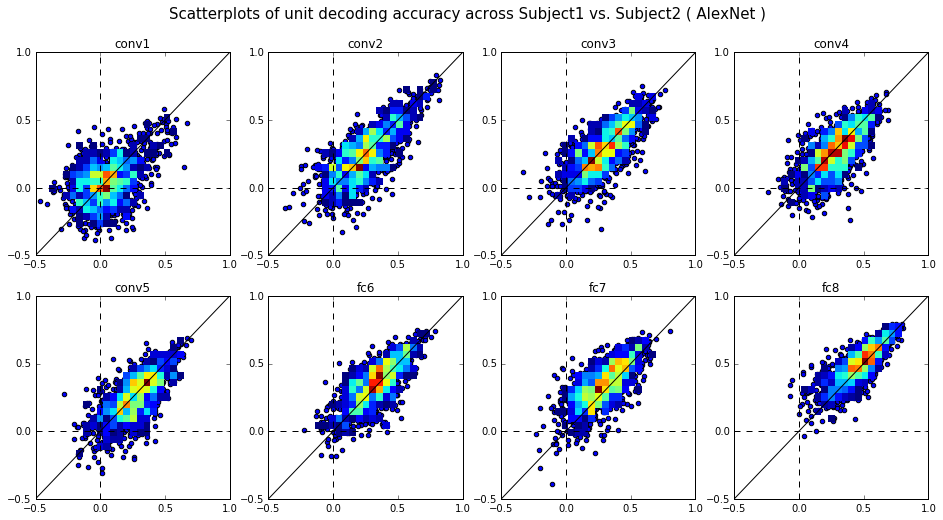

In [8]:
# Figure 2b ( Scatterplots of unit decoding accuracy across two subjects )
plot_range = [ -0.5, 1.0]
n_feature  =  1000     # number of features to be plotted

idx_sbj1 = 0 # Subject 1
idx_sbj2 = 1 # subject 2

plt.figure(figsize=(16,8))
plt.suptitle('Scatterplots of unit decoding accuracy across ' + 
             'Subject' + str(idx_sbj1+1) + ' vs. ' +
             'Subject' + str(idx_sbj2+1) + ' ( ' + net + ' )', fontsize=15)

idx_subplot = 0
sub_shape = [2,4] if net == 'AlexNet' else [3,7]
for layer in layers:
    s1_acc = acc_data[layer][idx_sbj1].flatten()   # acc for S1
    s2_acc = acc_data[layer][idx_sbj2].flatten()   # acc for S2
    
    idx_feature = np.random.permutation(s1_acc.shape[0])
    idx_feature = idx_feature[0:n_feature] if len(idx_feature) > n_feature else idx_feature
    
    idx_subplot += 1
    plt.subplot(sub_shape[0], sub_shape[1], idx_subplot)
    plt.scatter(s1_acc[idx_feature], s2_acc[idx_feature],zorder=0)
    plt.hist2d(s1_acc[idx_feature], s2_acc[idx_feature], 
               cmin=2.5, 
               bins=[ np.linspace( plot_range[0], plot_range[1], 30),np.linspace( plot_range[0], plot_range[1],30)],
               zorder=1 )
    
    plt.plot( plot_range, plot_range, 'k')
    plt.vlines(0.0, plot_range[0], plot_range[1], linestyles='dashed')
    plt.hlines(0.0, plot_range[0], plot_range[1], linestyles='dashed')
    
    plt.xticks([-0.5, 0, 0.5, 1])
    plt.yticks([-0.5, 0, 0.5, 1])
    plt.title(layer)
    
plt.show()

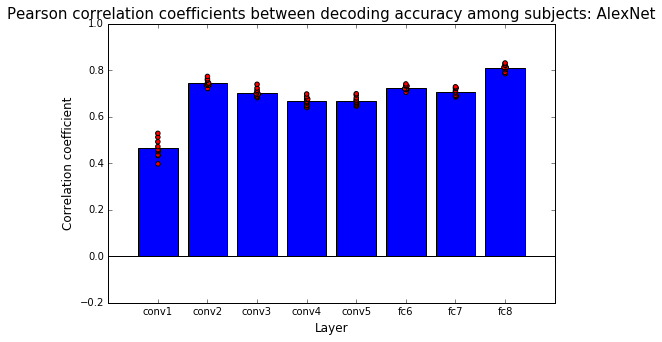

In [9]:
# Figure 2c ( Pearson correlation coefficients between decoding accuracy among subjects )
data = []
mean_data = []
n_subject = len(subjects)
for layer in layers:
    acc_flat = np.array([ acc.flatten() for acc in acc_data[layer] ])
    corr = np.corrcoef(acc_flat)
    non_diag_elements = np.array([ corr[i,j] for i in range(n_subject) for j in range(i+1,n_subject) ])
    data.append( non_diag_elements )
    corr_mean = non_diag_elements.mean()
    mean_data.append(corr_mean)
    
fig = plt.figure(figsize=(n_layers,5))
plt.bar( range(n_layers), mean_data, tick_label=layers, align='center',zorder=1)
beeswarm.beeswarm(data, method="swarm", ax=fig.axes[0], s= 1, col='red',zorder=2 )

plt.hlines(0.0, -1.0,n_layers)

plt.xlim( [-1.0, n_layers])
plt.ylim( [ -0.2, 1.0 ])
plt.title('Pearson correlation coefficients between decoding accuracy among subjects: ' + net, fontsize=15)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Correlation coefficient', fontsize=12)

plt.show()